In [44]:
import math
import numpy as np
import matplotlib.pyplot as plt



Derive the attinuation parameter 

In [45]:
data = [
    (90, 200, 17.76),
]
pitch = 0.813 

results = []
for kVp, mAs, ctdi in data:
    volt = kVp
    denom = (volt**2 * mAs) / pitch
    C = ctdi / denom
    results.append((kVp, mAs, C))

C_vals = np.array([r[2] for r in results])

A = C_vals.mean()
print(f"A = {A}")



A = 8.91288888888889e-06


Derive the scaling factor

In [ ]:
data = [
    (90, 200, 7.26),
]

time = 1    # seconds
slice = 0.0025    # meters (slice thickness)

def mew(e):
    return (0.4259 * e)**(-0.696)

k_vals = []

for kVp, mAs, snr in data:
    energy_mean = kVp/2.5    # keV
    mu = mew(energy_mean)
    current = mAs
    SNR = snr
    
    k = (SNR**2 * energy_mean) / ( (kVp**2) * current * math.exp(-mu * slice) * time )
    k_vals.append((kVp, mAs, k))

k_only = np.array([row[2] for row in k_vals])
k = k_only.mean()
print(f"k = {k}")


k = 0.0011717180233598735


Objective functions

In [ ]:

def snr_formula(k, V, I, t, e_mean, x):
    mu = mew(e_mean)
    return np.sqrt((k * (V**2) * I * np.exp(-mu * x) * t) / e_mean)

def ctdi_formula(A, V, I, t, P):
    return A * V * V * I * t * (1.0 / P)

Ranges of accepted values

In [48]:

bounds = {
    "I": (10, 640),             # mA
    "V": (80.0, 140.0),         # kV
    "P": (0.5, 1.5),            # pitch
    "t": (0.5, 1),              # seconds
    "x": (0.625e-3, 10e-3),     # meters
    "e_mean": (35.0, 70.0)      # keV
}

### Discountinous method

Create 20000 random samples of teh variabels within their ranges

In [ ]:
n_samples = 20000  # sampling resolution
n_weights = 101    # number of weights in [0,1] to sweep

rng = np.random.default_rng(0)

def sample_design_space(n):
    I = rng.uniform(bounds["I"][0], bounds["I"][1], size=n)
    V = rng.uniform(bounds["V"][0], bounds["V"][1], size=n)
    P = rng.uniform(bounds["P"][0], bounds["P"][1], size=n)
    t = rng.uniform(bounds["t"][0], bounds["t"][1], size=n)
    x = rng.uniform(bounds["x"][0], bounds["x"][1], size=n)
    e_mean = rng.uniform(bounds["e_mean"][0], bounds["e_mean"][1], size=n)
    return I, V, P, t, x, e_mean


I_s, V_s, P_s, t_s, x_s, e_mean_s = sample_design_space(n_samples)

# Apply constraints
valid_mask = (V_s * I_s <= 80000) & (V_s * I_s * t_s <= 56800)

# Keep only feasible points
I_s = I_s[valid_mask]
V_s = V_s[valid_mask]
P_s = P_s[valid_mask]
t_s = t_s[valid_mask]
x_s = x_s[valid_mask]
e_mean_s = e_mean_s[valid_mask]

snr_vals = snr_formula(k, V_s, I_s, t_s, e_mean_s, x_s)
ctdi_vals = ctdi_formula(A, V_s, I_s, t_s, P_s)


Find the min and max of each objective function seperately

In [50]:
snr_min, snr_max = float(np.min(snr_vals)), float(np.max(snr_vals))
ctdi_min, ctdi_max = float(np.min(ctdi_vals)), float(np.max(ctdi_vals))

print(f"Sampled SNR range: min={snr_min:.6g}, max={snr_max:.6g}")
print(f"Sampled CTDI range: min={ctdi_min:.6g}, max={ctdi_max:.6g}")

Sampled SNR range: min=0.931894, max=15.859
Sampled CTDI range: min=0.329318, max=134.157


This is covered by the sampling, but just computes the ideal min values of each function. Effectively, it gets the max SNR and min CTDI

In [ ]:
# For SNR maximize
idx_max_snr = np.argmax(snr_vals)
fstar_snr = snr_vals[idx_max_snr]
design_fstar_snr = {
    "I": I_s[idx_max_snr], "V": V_s[idx_max_snr], "P": P_s[idx_max_snr],
    "t": t_s[idx_max_snr], "x": x_s[idx_max_snr], "e_mean": e_mean_s[idx_max_snr]
}

# For CTDI minimize
idx_min_ctdi = np.argmin(ctdi_vals)
fstar_ctdi = ctdi_vals[idx_min_ctdi]
design_fstar_ctdi = {
    "I": I_s[idx_min_ctdi], "V": V_s[idx_min_ctdi], "P": P_s[idx_min_ctdi],
    "t": t_s[idx_min_ctdi], "x": x_s[idx_min_ctdi], "e_mean": e_mean_s[idx_min_ctdi]
}

print("\nIdeal (sampled) solutions f*:")
print(f" - f*_SNR  = {fstar_snr:.6g} at sample index {idx_max_snr}")
print(f" - f*_CTDI = {fstar_ctdi:.6g} at sample index {idx_min_ctdi}")


Ideal (sampled) solutions f*:
 - f*_SNR  = 15.859 at sample index 4323
 - f*_CTDI = 0.329318 at sample index 3829


For SNR:
distance is how much worse the sample is than the best SNR found

For CTDI:
distance is how much worse the sample is than the best CTDI found

Distances are normalized so that both objectives are scaled comparably.

In [ ]:
# normalize denominators (avoid zero division)
snr_range = snr_max - snr_min if (snr_max - snr_min) > 0 else 1.0
ctdi_range = ctdi_max - ctdi_min if (ctdi_max - ctdi_min) > 0 else 1.0

d_snr = (fstar_snr - snr_vals) / snr_range
d_ctdi = (ctdi_vals - fstar_ctdi) / ctdi_range

For each weight value:
- Compute the weighted distance for every sampled solution
- Pick the solution that has the smallest distance
- Store it

In [ ]:
# Euclidean Weighted Matrix sweep over weights
weights = np.linspace(0, 1, n_weights)
selected_indices = []
selected_info = []

for w in weights:
    # weighted Euclidean distance (two objectives)
    dist = np.sqrt(w * (d_snr ** 2) + (1 - w) * (d_ctdi ** 2))
    idx = int(np.argmin(dist))
    if idx not in selected_indices:
        selected_indices.append(idx)
        selected_info.append({
            "weight": float(w),
            "index": idx,
            "I": float(I_s[idx]), "V": float(V_s[idx]), "P": float(P_s[idx]),
            "t": float(t_s[idx]), "x": float(x_s[idx]), "e_mean": float(e_mean_s[idx]),
            "snr": float(snr_vals[idx]), "ctdi": float(ctdi_vals[idx])
        })

print(f"\nNumber of unique solutions found by EWM weight sweep: {len(selected_info)}", "selected info", selected_info)


Number of unique solutions found by EWM weight sweep: 15 selected info [{'weight': 0.0, 'index': 3829, 'I': 10.724792083853544, 'V': 80.1698495812784, 'P': 1.1435795113523155, 't': 0.6129876627052794, 'x': 0.0019504810288394365, 'e_mean': 39.18247517665824, 'snr': 1.1239248662713455, 'ctdi': 0.32931755278784564}, {'weight': 0.01, 'index': 11117, 'I': 112.40648781113532, 'V': 91.32471131585564, 'P': 1.4711842386296299, 't': 0.8637752233107772, 'x': 0.004616126715840894, 'e_mean': 35.15244472537833, 'snr': 5.193566946494201, 'ctdi': 4.905916655803319}, {'weight': 0.02, 'index': 15935, 'I': 154.30672352382817, 'V': 118.1200475551786, 'P': 1.4983119518591175, 't': 0.5674954678012873, 'x': 0.005891908746479955, 'e_mean': 35.3333091476512, 'snr': 6.362426535494697, 'ctdi': 7.267929771301099}, {'weight': 0.03, 'index': 6195, 'I': 438.55381203334804, 'V': 82.45629250399136, 'P': 1.4821221598909031, 't': 0.5012359561265229, 'x': 0.005485614412383939, 'e_mean': 35.48519738174549, 'snr': 7.02205

Using nondominated sorting:

A solution A dominates solution B if:

A has ≥ SNR than B, and

A has ≤ CTDI than B, and

at least one is strict (better)

All solutions that are not dominated by any other form the Pareto front.

This gives an independent check of the multi-objective result.

In [ ]:
# compute approximate Pareto front via nondominated sorting
def nondominated_sort(snr, ctdi):
    n = len(snr)
    is_pareto = np.ones(n, dtype=bool)

    for i in range(n):
        if not is_pareto[i]:
            continue

        # Compare to all other points
        for j in range(n):
            if i == j:
                continue

            # Check if j dominates i
            if ((snr[j] >= snr[i]) and
                (ctdi[j] <= ctdi[i]) and
                ((snr[j] > snr[i]) or (ctdi[j] < ctdi[i]))):
                is_pareto[i] = False
                break

    return is_pareto


pareto_mask = nondominated_sort(snr_vals, ctdi_vals)
pareto_indices = np.where(pareto_mask)[0]
print(f"Approximate Pareto set size (from sampled points): {len(pareto_indices)}")


Approximate Pareto set size (from sampled points): 108


In [ ]:
print("\nSample of EWM-selected solutions (weight, snr, ctdi, V, I, P, t, x, e_mean):")
for s in selected_info:
    print(f"w={s['weight']:.3f}  SNR={s['snr']:.6g}  CTDI={s['ctdi']:.6g}  "
          f"V={s['V']:.3f}  I={s['I']:.3f}  P={s['P']:.3f}  t={s['t']:.3f}  x={s['x']:.6g}  e_mean={s['e_mean']:.3f}")

results = {
    "samples": {
        "I": I_s, "V": V_s, "P": P_s, "t": t_s, "x": x_s, "e_mean": e_mean_s
    },
    "objectives": {
        "snr": snr_vals, "ctdi": ctdi_vals,
        "snr_min": snr_min, "snr_max": snr_max,
        "ctdi_min": ctdi_min, "ctdi_max": ctdi_max
    },
    "fstar": {
        "snr": fstar_snr, "ctdi": fstar_ctdi,
        "design_fstar_snr": design_fstar_snr, "design_fstar_ctdi": design_fstar_ctdi
    },
    "ewm_selected": selected_info,
    "pareto_indices": pareto_indices
}


Sample of EWM-selected solutions (weight, snr, ctdi, V, I, P, t, x, e_mean):
w=0.000  SNR=1.12392  CTDI=0.329318  V=80.170  I=10.725  P=1.144  t=0.613  x=0.00195048  e_mean=39.182
w=0.010  SNR=5.19357  CTDI=4.90592  V=91.325  I=112.406  P=1.471  t=0.864  x=0.00461613  e_mean=35.152
w=0.020  SNR=6.36243  CTDI=7.26793  V=118.120  I=154.307  P=1.498  t=0.567  x=0.00589191  e_mean=35.333
w=0.030  SNR=7.02206  CTDI=8.98767  V=82.456  I=438.554  P=1.482  t=0.501  x=0.00548561  e_mean=35.485
w=0.040  SNR=7.35961  CTDI=9.91307  V=82.617  I=373.875  P=1.464  t=0.638  x=0.00386579  e_mean=35.203
w=0.050  SNR=8.28377  CTDI=12.5232  V=112.064  I=183.754  P=1.467  t=0.893  x=0.00462558  e_mean=35.179
w=0.070  SNR=8.78341  CTDI=14.1851  V=84.604  I=423.941  P=1.456  t=0.764  x=0.0022483  e_mean=35.193
w=0.100  SNR=10.0312  CTDI=18.3909  V=117.279  I=295.346  P=1.469  t=0.746  x=0.000907384  e_mean=35.291
w=0.170  SNR=11.8295  CTDI=25.0189  V=106.472  I=470.706  P=1.492  t=0.785  x=0.00582841  e_mea

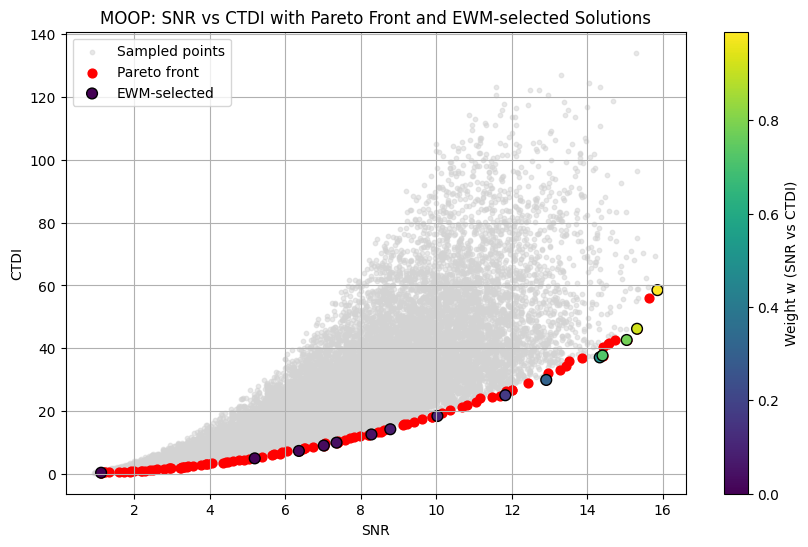

In [ ]:

snr_vals = results["objectives"]["snr"]
ctdi_vals = results["objectives"]["ctdi"]

pareto_indices = results["pareto_indices"]

# Extract EWM-selected SNR and CTDI
ewm_snr = np.array([s['snr'] for s in selected_info])
ewm_ctdi = np.array([s['ctdi'] for s in selected_info])
ewm_weights = np.array([s['weight'] for s in selected_info])

# Plot
plt.figure(figsize=(10, 6))

# All sampled points (light gray)
plt.scatter(snr_vals, ctdi_vals, s=10, color='lightgray', alpha=0.5, label='Sampled points')

# Pareto front points (red)
plt.scatter(snr_vals[pareto_indices], ctdi_vals[pareto_indices], s=40, color='red', label='Pareto front')

# EWM-selected solutions (colored by weight)
scatter = plt.scatter(ewm_snr, ewm_ctdi, s=60, c=ewm_weights, cmap='viridis', edgecolor='black', label='EWM-selected')

# Colorbar for weights
cbar = plt.colorbar(scatter)
cbar.set_label('Weight w (SNR vs CTDI)')

# Labels and title
plt.xlabel('SNR')
plt.ylabel('CTDI')
plt.title('MOOP: SNR vs CTDI with Pareto Front and EWM-selected Solutions')
plt.legend()
plt.grid(True)
plt.show()


### Continuous method

Using NSGA-II: without additional constrains

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     22 |             - |             -
     2 |      400 |     33 |  0.0107842420 |             f
     3 |      600 |     49 |  0.0891195747 |         ideal
     4 |      800 |     68 |  0.0243367456 |         ideal
     5 |     1000 |     90 |  0.0590901980 |         ideal
     6 |     1200 |    115 |  0.0488737280 |         nadir
     7 |     1400 |    130 |  0.0080362558 |         ideal
     8 |     1600 |    159 |  0.0027335756 |             f
     9 |     1800 |    187 |  0.0025092353 |             f
    10 |     2000 |    200 |  0.0220436672 |         ideal
    11 |     2200 |    200 |  0.0016810531 |             f
    12 |     2400 |    200 |  0.0077506949 |         nadir
    13 |     2600 |    200 |  0.0013803295 |             f
    14 |     2800 |    200 |  0.0132087375 |         ideal
    15 |     3000 |    200 |  0.0012024143 |             f
    16 |     3200 |    200 |  0.0017118823 |            

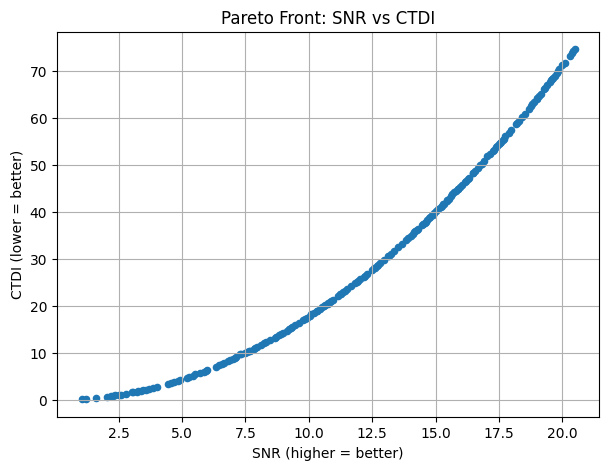

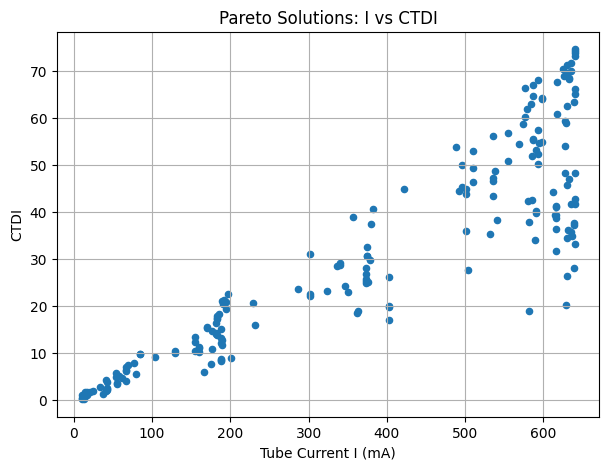

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# Just putting these here again
def mew(e):
    return (0.4259 * e) ** (-0.696)

def snr_formula(k, V, I, t, e_mean, x):
    mu = mew(e_mean)
    val = (k * V**2 * I * math.exp(-mu * x) * t) / e_mean
    return math.sqrt(max(val, 0.0))

def ctdi_formula(A, V, I, t, P):
    return A * V * V * I * t / P

# Bounds
xl = np.array([10.0, 80.0, 0.5, 0.5, 0.625e-3, 35.0])
xu = np.array([640.0, 140.0, 1.5, 1.0, 10e-3, 70.0])

class CTDI_SNR_Problem(Problem):
    def __init__(self, A, k, xl, xu):
        super().__init__(
            n_var=6,
            n_obj=2,
            n_constr=0,
            xl=xl,
            xu=xu,
            elementwise=True
        )
        self.A = A
        self.k = k

    def _evaluate(self, x, out, *args, **kwargs):
        I, V, P, t, x_slice, e_mean = x

        ctdi = ctdi_formula(self.A, V, I, t, P)
        snr = snr_formula(self.k, V, I, t, e_mean, x_slice)

        out["F"] = np.array([ctdi, -snr])

problem = CTDI_SNR_Problem(A=A, k=k, xl=xl, xu=xu)


algorithm = NSGA2(
    pop_size=200,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

res = minimize(
    problem,
    algorithm,
    ("n_gen", 400),
    seed=42,
    verbose=True
)

# Results
F = res.F
X = res.X

ctdi_vals = F[:, 0]
snr_vals = -F[:, 1]

print("\nFound", len(ctdi_vals), "Pareto-optimal solutions")
print("Sample solutions: (CTDI, SNR, params)\n")
for i in range(min(10, len(ctdi_vals))):
    print(f"{i+1:2d}: CTDI={ctdi_vals[i]:.6e},  SNR={snr_vals[i]:.3f},  params={X[i]}")

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(snr_vals, ctdi_vals, s=20)
plt.xlabel("SNR (higher = better)")
plt.ylabel("CTDI (lower = better)")
plt.title("Pareto Front: SNR vs CTDI")
plt.grid(True)
plt.show()


WIth constraints

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |     25 |  0.000000E+00 |  4.377440E+02 |             - |             -
     2 |      400 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0113056138 |             f
     3 |      600 |     46 |  0.000000E+00 |  0.000000E+00 |  0.0182304182 |         ideal
     4 |      800 |     58 |  0.000000E+00 |  0.000000E+00 |  0.0229760092 |         nadir
     5 |     1000 |     60 |  0.000000E+00 |  0.000000E+00 |  0.0132739731 |         ideal
     6 |     1200 |     86 |  0.000000E+00 |  0.000000E+00 |  0.0193080433 |         ideal
     7 |     1400 |    114 |  0.000000E+00 |  0.000000E+00 |  0.0047813222 |             f
     8 |     1600 |    139 |  0.000000E+00 |  0.000000E+00 |  0.0068487978 |         nadir
     9 |     1800 |    178 |  0.000000E+00 |  0.000000E+00 |  0.0060541679 |         ideal
    10 |     2000 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0012921303 |             f

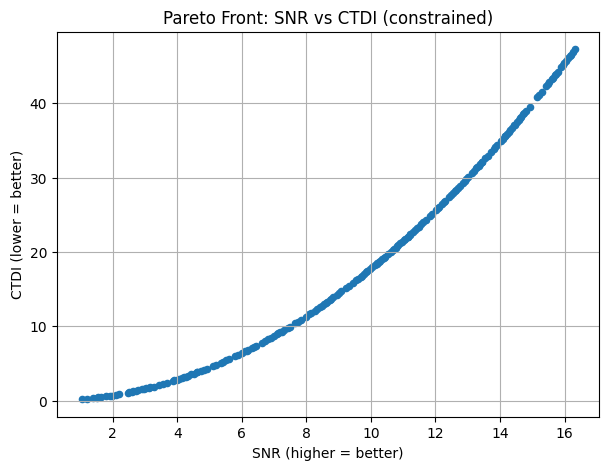

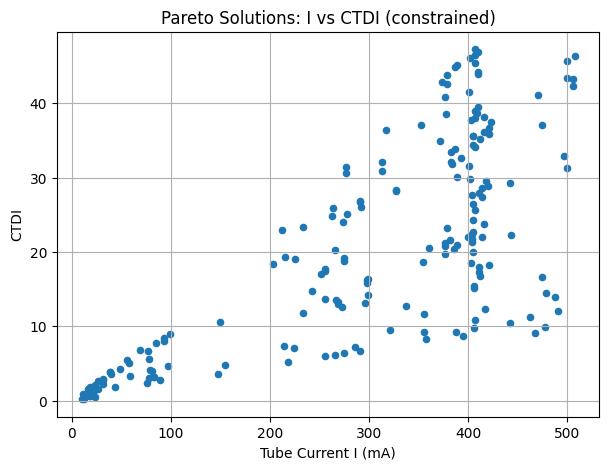

Min/max of decision variables:
I: 10.00000006470433 507.4455500717554
V: 80.0000158998196 139.99999995322267
P: 1.4729556715998209 1.4999999175318461
t: 0.5000001716527216 0.9996280002236989
slice_thickness: 0.0006261058475716058 0.0029402820837698225
e_mean: 35.000000123761474 35.87857341607996


In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

def mew(e):
    return (0.4259 * e) ** (-0.696)

def e_mean(V):
    return 1/3 * V

def snr_formula(k, V, I, t, e_mean, x):
    mu = mew(e_mean)
    val = (k * V**2 * I * math.exp(-mu * x) * t) / e_mean
    return math.sqrt(max(val, 0.0))

def ctdi_formula(A, V, I, t, P):
    return A * V * V * I * t / P

xl = np.array([10.0, 80.0, 0.5, 0.5, 0.625e-3, 35.0])
xu = np.array([640.0, 140.0, 1.5, 1.0, 10e-3, 70.0])

class CTDI_SNR_Problem(Problem):
    def __init__(self, A, k, xl, xu):
        super().__init__(
            n_var=6,
            n_obj=2,
            n_constr=2, # two constraints
            xl=xl,
            xu=xu,
            elementwise=True
        )
        self.A = A
        self.k = k

    def _evaluate(self, x, out, *args, **kwargs):
        I, V, P, t, x_slice, e_mean = x

        # Objectives
        ctdi = ctdi_formula(self.A, V, I, t, P)
        snr = snr_formula(self.k, V, I, t, e_mean, x_slice)
        out["F"] = np.array([ctdi, -snr])

        # Constraints 
        g1 = V * I - 80000        # Power
        g2 = V * I * t - 56800    # energy
        out["G"] = np.array([g1, g2])

problem = CTDI_SNR_Problem(A=A, k=k, xl=xl, xu=xu)

algorithm = NSGA2(
    pop_size=200,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

res = minimize(
    problem,
    algorithm,
    ("n_gen", 400),
    seed=42,
    verbose=True
)

# Results
F = res.F
X = res.X

ctdi_vals = F[:, 0]
snr_vals = -F[:, 1]

print("\nFound", len(ctdi_vals), "Pareto-optimal solutions")
print("Sample solutions: (CTDI, SNR, params)\n")
for i in range(min(10, len(ctdi_vals))):
    print(f"{i+1:2d}: CTDI={ctdi_vals[i]:.6e},  SNR={snr_vals[i]:.3f},  params={X[i]}")

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(snr_vals, ctdi_vals, s=20)
plt.xlabel("SNR (higher = better)")
plt.ylabel("CTDI (lower = better)")
plt.title("Pareto Front: SNR vs CTDI (constrained)")
plt.grid(True)
plt.show()

print("Min/max of decision variables:")
print("I:", X[:,0].min(), X[:,0].max())
print("V:", X[:,1].min(), X[:,1].max())
print("P:", X[:,2].min(), X[:,2].max())
print("t:", X[:,3].min(), X[:,3].max())
print("slice_thickness:", X[:,4].min(), X[:,4].max())
print("e_mean:", X[:,5].min(), X[:,5].max())


In [64]:
print("\nOptimization Stats:")
print("Number of generations run:", res.algorithm.n_gen)
print("Population size:", res.algorithm.pop_size)
print("Number of Pareto-optimal solutions:", len(res.F))



Optimization Stats:
Number of generations run: 401
Population size: 200
Number of Pareto-optimal solutions: 200
